In [1]:
# Imports
import random
import string
import tempfile
import shutil
import subprocess as sp
import os

from PIL import Image
from torch import nn as nn
from torch import Generator
from torch.utils.data import random_split,DataLoader
# TODO: Currently assumes that pytest runs from project root
from util.car_dataset import check_dir, check_file, CarDataset, DatasetError
from networks.common import *
from networks.CNNbase import CNNBasic

In [2]:
root = os.getcwd()
print(os.getcwd())

/home/akshay.viswakumar/dl-based-sensor-calib


In [3]:
# Set Up Paths and Metadata for Storing Values
test_class = "Regularization"
test_name = "alpha05"
epochs = 21
checkpoint_path = os.path.join(root,"Test-Results",test_class,test_name)

In [4]:
# Helper Functions
def rand_string(length=5):
    return ''.join(random.choices(string.ascii_letters +
        string.digits, k=length))

def loaded_dataset(temp_dir):
    '''
    Loads the car_dataset and returns the CarDataset object.
    '''
    image_folder_list = ['0_Frames','1_Frames','2_Frames','3_Frames']
    label_file_list = ['0.txt','1.txt','2.txt','3.txt']
    #image_folder_list = ['0_Frames']
    #label_file_list = ['0.txt']
    car_data = CarDataset(temp_dir,image_folder_list,label_file_list)
    car_data.drop_nan()

    return car_data

def dataset_loader(loaded_dataset):
    length = len(loaded_dataset)
    split_set = random_split(loaded_dataset,[round(0.80*length)
                ,round(0.20*length)],generator=Generator().manual_seed(42))
    train_loader = DataLoader(split_set[0],batch_size=20)
    test_loader = DataLoader(split_set[1],batch_size=20)
    '''
    Lowering values to sane levels to help run tests on github
    runners. Ideally on local GPU (4GB) 80/20 split with batch size of
    30 works well.
    '''
    return (train_loader,test_loader)

def network(alpha=0):
    network = CNNBasic(alpha)
    network = network.to(get_device())
    network.double()
    return network

In [5]:
# Load Data
data = loaded_dataset(os.path.join(root,"dummy"))

In [6]:
# Split Dataset
datasets = dataset_loader(data)

In [7]:
# Initialize Network
net = network(alpha=0.5)

In [8]:
# Train
train = datasets[0]
test = datasets[1]
print("Start Training")
losses = run_training(net,train,test,epochs,get_device(),checkpoint_path,test_name,checkpoint_freq=5)

0it [00:00, ?it/s]

Start Training


149it [04:56,  1.99s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000665
Train Epoch: 0	Train Loss: 0.001797 Test Loss:0.000665


149it [05:04,  2.05s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000690
Train Epoch: 1	Train Loss: 0.000774 Test Loss:0.000690


149it [05:05,  2.05s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000766
Train Epoch: 2	Train Loss: 0.000764 Test Loss:0.000766


149it [05:03,  2.03s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000853
Train Epoch: 3	Train Loss: 0.000811 Test Loss:0.000853


149it [05:05,  2.05s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000829
Train Epoch: 4	Train Loss: 0.000844 Test Loss:0.000829


149it [05:00,  2.01s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000680
Train Epoch: 5	Train Loss: 0.000743 Test Loss:0.000680


149it [04:59,  2.01s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000561
Train Epoch: 6	Train Loss: 0.000600 Test Loss:0.000561


149it [05:02,  2.03s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000502
Train Epoch: 7	Train Loss: 0.000513 Test Loss:0.000502


149it [05:02,  2.03s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000476
Train Epoch: 8	Train Loss: 0.000473 Test Loss:0.000476


149it [03:41,  1.49s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000466
Train Epoch: 9	Train Loss: 0.000457 Test Loss:0.000466


149it [03:20,  1.35s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000462
Train Epoch: 10	Train Loss: 0.000450 Test Loss:0.000462


149it [03:39,  1.47s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000461
Train Epoch: 11	Train Loss: 0.000448 Test Loss:0.000461


149it [03:36,  1.46s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 12	Train Loss: 0.000447 Test Loss:0.000460


149it [03:19,  1.34s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 13	Train Loss: 0.000447 Test Loss:0.000460


149it [03:14,  1.31s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 14	Train Loss: 0.000447 Test Loss:0.000460


149it [03:14,  1.31s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 15	Train Loss: 0.000447 Test Loss:0.000460


149it [03:15,  1.31s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 16	Train Loss: 0.000447 Test Loss:0.000460


149it [03:17,  1.32s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 17	Train Loss: 0.000447 Test Loss:0.000460


149it [03:41,  1.49s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 18	Train Loss: 0.000447 Test Loss:0.000460


149it [03:41,  1.49s/it]
0it [00:00, ?it/s]

Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 19	Train Loss: 0.000447 Test Loss:0.000460


149it [03:19,  1.34s/it]


Num = 38
Len = 742
Test Set Average Loss 0.000460
Train Epoch: 20	Train Loss: 0.000447 Test Loss:0.000460


In [9]:
# Save Loss Files
save_stats(losses[0],os.path.join(checkpoint_path,'train_loss.pkl')) # Train loss
save_stats(losses[1],os.path.join(checkpoint_path,'test_loss.pkl')) # Test Loss

In [10]:
import matplotlib.pyplot as plt

def plot_losses(test,train):
    plt.figure()
    plt.grid()
    plt.plot(train,label='train')
    plt.plot(test,label='test')
    plt.legend()

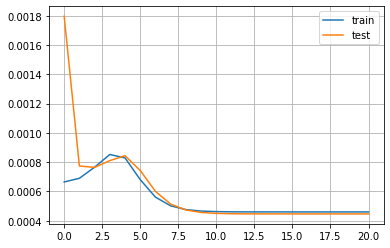

In [11]:
plot_losses(losses[0],losses[1])

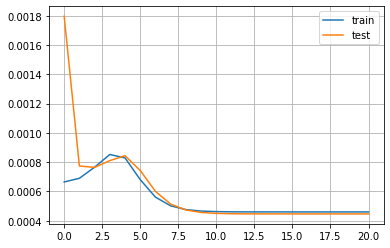

In [12]:
# Just a Backup Test
plot_losses(load_stats(os.path.join(checkpoint_path,'train_loss.pkl')),load_stats(os.path.join(checkpoint_path,'test_loss.pkl')))